<a href="https://colab.research.google.com/github/codecakes/ud_students_data_analysis/blob/master/ud_students_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import datetime as dt
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
%config IPCompleter.greedy=True


# Wrangling Phase

## Load DF.

In [596]:
# Mount Google drive for data set.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
root_path = r'gdrive/My Drive/Colab Notebooks/ud_data_analysis'

In [0]:
def toDateTimeFormat(df, cols):
  df[cols] = df[cols].transform(
      lambda col: pd.to_datetime(col, errors='raise',
                                 infer_datetime_format=True))

In [599]:
f = os.path.join(root_path, 'daily_engagement.csv')
daily_engagement_sample_df = pd.read_csv(
    f, infer_datetime_format=True, engine='c')
daily_engagement_sample_df.head(2)

,acct,utc_date,num_courses_visited,total_minutes_visited,lessons_completed,projects_completed
0,0,2015-01-09,1.0,11.679374,0.0,0.0
1,0,2015-01-10,2.0,37.284887,0.0,0.0


In [0]:
f = os.path.join(root_path, 'daily_engagement_full.csv')
columns = ['utc_date', 'acct', 'registration_date', 'subscription_start',
       'course_key', 'sibling_key', 'course_title', 'has_visited',
       'total_minutes_visited', 'lessons_completed', 'projects_completed',
       'account_key']
engagements = pd.read_csv(
    f, infer_datetime_format=True, engine='c', usecols=columns)
engagements.astype({k: str for k in ['acct', 'course_key', 'sibling_key', 'course_title', 'account_key']})
engagements.astype({k: 'datetime64[ns]' for k in ['utc_date', 'registration_date', 'subscription_start']})
toDateTimeFormat(engagements, ['registration_date', 'subscription_start'])

In [0]:
f = os.path.join(root_path, 'enrollments.csv')
columns=['account_key', 'status', 'join_date', 'cancel_date', 'days_to_cancel',
       'is_udacity', 'is_canceled']
enrollments = pd.read_csv(
    f, infer_datetime_format=True, engine='c', usecols=columns)
enrollments.astype({
    'join_date': 'datetime64[ns]',
    'cancel_date': 'datetime64[ns]', 
    'account_key': str,
    'status': str,
    'days_to_cancel': float,
    'is_udacity': bool,
    'is_canceled': bool,
    })
toDateTimeFormat(enrollments, ['join_date', 'cancel_date'])

In [0]:

cols =['join_date', 'cancel_date']
enrollments[cols] = enrollments[cols].transform(
    lambda row: pd.to_datetime(row, errors='raise', 
                               infer_datetime_format=True), axis=1)

In [0]:
f = os.path.join(root_path, 'project_submissions.csv')
project_submissions = pd.read_csv(
    f, infer_datetime_format=True, engine='c')
project_submissions.astype({
    'creation_date': 'datetime64[ns]',
    'completion_date': 'datetime64[ns]',
    'assigned_rating': str,
    'account_key': str,
    'lesson_key': str,
    })
toDateTimeFormat(project_submissions, ['creation_date', 'completion_date'])

How many students enrolled?

How many students passed/failed/didnt finish?

when did students frequently join?

is there a correlation between students joining/completing projects vs pass status?





## Size Before Cleaning

In [604]:
enrollments.shape, engagements.shape, project_submissions.shape

((1640, 7), (2309239, 12), (3642, 6))

In [0]:
# Update only valid accounts.
def resetIndex(df1):
  df1.reset_index(inplace=True)
  return df1

# Remove all Test Udacity accounts.
filter_enrollments = enrollments[enrollments['is_udacity'] == False]
valid_accounts = filter_enrollments['account_key']
filter_engagements = engagements[engagements['acct'].isin(valid_accounts)]
valid_submissions = project_submissions['account_key'].isin(valid_accounts)
filter_project_submissions = project_submissions[valid_submissions]

In [0]:
enrollments = resetIndex(filter_enrollments)
engagements = resetIndex(filter_engagements)
project_submissions = resetIndex(filter_project_submissions)

## Size After Cleaning

In [607]:
enrollments.shape, engagements.shape, project_submissions.shape

((1622, 8), (2299629, 13), (3626, 7))

# Exploration

### Get Total Unique Engagements, Enrollments, Submissions

In [0]:
uniq_student_engagement=engagements.drop_duplicates(subset=['acct'])
uniq_student_enrollment = enrollments.drop_duplicates(subset=['account_key'])
uniq_student_submission = project_submissions.drop_duplicates(subset=['account_key'])


In [609]:
uniq_student_engagement.size

16042

In [610]:
uniq_student_enrollment.size

10368

In [611]:
uniq_student_submission.size

5159

In [612]:
uniq_student_enrollment.tail(5)

,index,account_key,status,join_date,cancel_date,days_to_cancel,is_udacity,is_canceled
1617,1635,1176,current,2015-08-12,NaT,NaN,False,False
1618,1636,1110,current,2015-08-13,NaT,NaN,False,False
1619,1637,1116,canceled,2015-08-15,2015-08-18,3.0,False,True
1620,1638,874,current,2015-08-22,NaT,NaN,False,False
1621,1639,686,current,2015-08-23,NaT,NaN,False,False


In [613]:
uniq_student_engagement.tail(5)

,index,utc_date,acct,registration_date,subscription_start,course_key,sibling_key,course_title,has_visited,total_minutes_visited,lessons_completed,projects_completed,account_key
2299249,2308859,2015-08-23,686,2012-10-20,2015-08-23,ud032-nd,ud032,Data Wrangling with MongoDB,0.0,0.0,0.0,0.0,u28015558
2299268,2308878,2015-08-23,1067,2012-08-30,2015-08-22,ud120-nd,ud120,Intro to Machine Learning,0.0,0.0,0.0,0.0,u20522597
2299363,2308973,2015-08-23,874,2015-08-05,2015-08-22,ud651-nd,ud651,Data Analysis with R,0.0,0.0,0.0,0.0,4804719296
2299458,2309068,2015-08-23,754,2015-01-22,2015-08-21,ud359-nd,ud359,Intro to Data Science,0.0,0.0,0.0,0.0,3567109205
2299553,2309163,2015-08-23,854,2012-10-12,2015-08-23,ud359-nd,ud359,Intro to Data Science,0.0,0.0,0.0,0.0,u26334020


In [0]:
uniq_enrolled_accounts = uniq_student_enrollment['account_key']
uniq_engagement_accounts = uniq_student_engagement['acct']

In [615]:
uniq_enrolled_accounts.size

1296

In [616]:
uniq_engagement_accounts.size

1234

In [617]:
uniq_engagement_accounts.head(5)

0         44
4783     258
8799     366
11201    587
15287    943
Name: acct, dtype: int64

In [618]:
uniq_enrolled_accounts.head(5)

0     700
1     429
3      60
6    1300
7     369
Name: account_key, dtype: int64

### Get total Unique Accounts Enrolled but Not Engaged 

In [619]:
enrolled_not_engaged_accounts = uniq_enrolled_accounts[~uniq_enrolled_accounts.isin(uniq_engagement_accounts)]
enrolled_not_engaged_accounts

56      1219
66       871
184     1218
207      654
211      964
        ... 
1483    1079
1525    1063
1545    1270
1590    1291
1595    1241
Name: account_key, Length: 62, dtype: int64

### Students Enrolled But Not Engaged

In [620]:
uniq_student_enrollment[uniq_student_enrollment['account_key'].isin(enrolled_not_engaged_accounts)]

,index,account_key,status,join_date,cancel_date,days_to_cancel,is_udacity,is_canceled
56,65,1219,canceled,2014-11-12,2014-11-12,0.0,False,True
66,75,871,canceled,2014-11-13,2014-11-13,0.0,False,True
184,193,1218,canceled,2014-11-15,2014-11-15,0.0,False,True
207,216,654,canceled,2014-12-04,2014-12-04,0.0,False,True
211,220,964,canceled,2014-12-04,2014-12-04,0.0,False,True
...,...,...,...,...,...,...,...,...
1483,1501,1079,canceled,2015-02-09,2015-02-09,0.0,False,True
1525,1543,1063,canceled,2015-07-14,2015-07-14,0.0,False,True
1545,1563,1270,canceled,2015-07-20,2015-07-20,0.0,False,True
1590,1608,1291,canceled,2015-06-03,2015-06-03,0.0,False,True


## **Lets look at the project submissions grouped by accounts.**

In [621]:
project_submissions.head(5)

,index,creation_date,completion_date,assigned_rating,account_key,lesson_key,processing_state
0,0,2015-01-14,2015-01-16,UNGRADED,256,3176718735,EVALUATED
1,1,2015-01-10,2015-01-13,INCOMPLETE,256,3176718735,EVALUATED
2,2,2015-01-20,2015-01-20,PASSED,256,3176718735,EVALUATED
3,3,2015-03-10,2015-03-13,PASSED,434,3176718735,EVALUATED
4,4,2015-02-17,2015-03-03,INCOMPLETE,434,3176718735,EVALUATED


In [0]:
submissions_groupby_account = project_submissions.groupby(by='account_key', squeeze=True)

### Project submissions in descending order

In [623]:
submissions_groupby_account.size().sort_values(ascending=False)

account_key
569    27
281    20
427    17
426    17
641    17
       ..
88      1
534     1
243     1
771     1
64      1
Length: 737, dtype: int64

### Segregate Submitted Projects by their submission status(Assigned Rating)

In [0]:
project_grouped = project_submissions.groupby(by=['account_key', 'assigned_rating'])

In [625]:
project_grouped_size=project_grouped.size()
project_grouped_size

account_key  assigned_rating
0            INCOMPLETE         5
             PASSED             2
1            INCOMPLETE         1
             PASSED             2
2            PASSED             1
                               ..
1263         PASSED             1
1274         PASSED             1
1279         PASSED             1
1292         INCOMPLETE         1
1298         INCOMPLETE         2
Length: 1398, dtype: int64

In [626]:
project_grouped_size.sort_values(ascending=False)

account_key  assigned_rating
569          INCOMPLETE         20
281          INCOMPLETE         16
557          INCOMPLETE         13
641          INCOMPLETE         12
427          INCOMPLETE         11
                                ..
212          PASSED              1
493          INCOMPLETE          1
214          UNGRADED            1
215          INCOMPLETE          1
353          PASSED              1
Length: 1398, dtype: int64

In [0]:
project_grouped_sample = project_grouped.size().unstack(fill_value=0).head(10)

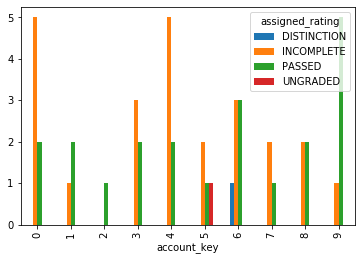

In [628]:
project_grouped_sample.plot.bar()

In [629]:
grouped_ratings = project_grouped.size().unstack(fill_value=0)
grouped_ratings

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
0,0,5,2,0
1,0,1,2,0
2,0,0,1,0
3,0,3,2,0
4,0,5,2,0
...,...,...,...,...
1263,0,0,1,0
1274,0,0,1,0
1279,0,0,1,0


In [630]:
grouped_ratings.sort_values(['DISTINCTION'], ascending=False)

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
553,2,3,3,2
627,2,3,0,0
156,2,3,0,0
45,2,2,1,0
280,1,4,2,0
...,...,...,...,...
254,0,5,3,2
255,0,2,2,0
256,0,1,1,1


In [631]:
grouped_ratings.sort_values(['DISTINCTION', 'PASSED'], ascending=False)

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
553,2,3,3,2
45,2,2,1,0
156,2,3,0,0
627,2,3,0,0
328,1,6,6,0
...,...,...,...,...
1206,0,1,0,0
1215,0,3,0,0
1247,0,2,0,0


In [632]:
grouped_ratings.sort_values(['PASSED'], ascending=False)

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
317,0,6,8,0
85,0,6,8,0
569,0,20,7,0
316,0,4,7,0
125,0,8,7,0
...,...,...,...,...
1002,0,1,0,0
1013,0,1,0,0
1033,0,3,0,0


In [633]:
grouped_ratings.sort_values(['INCOMPLETE'], ascending=False)

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
569,0,20,7,0
281,0,16,4,0
557,0,13,4,0
641,0,12,5,0
426,0,11,6,0
...,...,...,...,...
601,0,0,1,0
88,0,0,1,0
325,0,0,3,0


In [634]:
grouped_ratings.sort_values(['UNGRADED'], ascending=False)

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
553,2,3,3,2
755,0,0,0,2
620,0,1,1,2
473,0,1,1,2
254,0,5,3,2
...,...,...,...,...
263,0,5,4,0
264,0,0,1,0
265,0,0,1,0


## Lets look at the nature of Cumulative Submission Status 

In [635]:
grouped_ratings.agg(np.sum)

assigned_rating
DISTINCTION      36
INCOMPLETE     1903
PASSED         1623
UNGRADED         58
dtype: int64

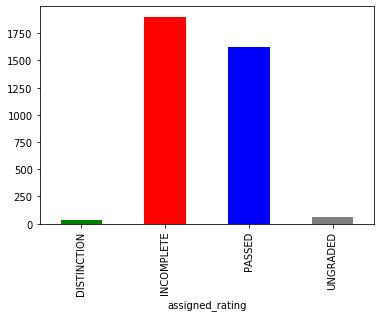

In [636]:
ratings_sum = grouped_ratings.agg(np.sum)
ax = ratings_sum.plot.bar(x=grouped_ratings.columns.values, 
                     color=['green', 'red', 'blue', 'gray'])

## Observations

*   There are **more Incomplete submissions** than **Passed**
*   There are **more Passed submissions** than **Ungraded**
*   The Ungraded submissions per account is not more than 2.
*   There are not more than 20 incomplete submissions per account.
*   At best an account has passed 8 submissions.
*   Someone doing very well **with Distinction** has **also had 
incomplete and ungraded submissions**. 




### Trend of Engaged Students over Period of time.

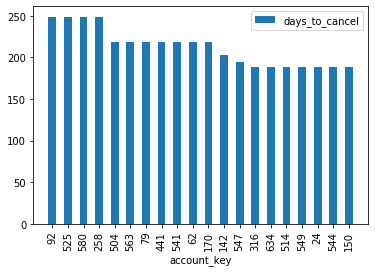

In [637]:
paid_students = enrollments[enrollments['days_to_cancel'] > 7]
ax = paid_students.sort_values(by='days_to_cancel', ascending=False)[:20].plot.bar(x='account_key', y='days_to_cancel')
ax.autoscale(tight=False)

In [638]:
p = paid_students[paid_students['account_key'] == 429]
p

,index,account_key,status,join_date,cancel_date,days_to_cancel,is_udacity,is_canceled
1,10,429,canceled,2014-11-10,2015-03-10,120.0,False,True
2,11,429,canceled,2015-03-10,2015-06-17,99.0,False,True


In [639]:
tmp = engagements[engagements['acct'] == 429]
tmp[tmp['acct'].isin(paid_students['account_key'])]


,index,utc_date,acct,registration_date,subscription_start,course_key,sibling_key,course_title,has_visited,total_minutes_visited,lessons_completed,projects_completed,account_key
20370,25228,2014-11-10,429,2012-08-24,2014-11-10,ud120-nd,ud120,Intro to Machine Learning,1.0,2.798053,0.0,0.0,u19633984
20371,25229,2014-11-10,429,2012-08-24,2014-11-10,ud651-nd,ud651,Data Analysis with R,0.0,0.000000,0.0,0.0,u19633984
20372,25230,2014-11-10,429,2012-08-24,2014-11-10,ud507-nd,ud507,Data Visualization and D3.js,1.0,13.719307,0.0,0.0,u19633984
20373,25231,2014-11-10,429,2012-08-24,2014-11-10,ud032,ud032,Data Wrangling with MongoDB,0.0,0.000000,0.0,0.0,u19633984
20374,25232,2014-11-10,429,2012-08-24,2014-11-10,ud507,ud507,Data Visualization and D3.js,0.0,0.000000,0.0,0.0,u19633984
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23804,28662,2015-06-16,429,2012-08-24,2015-03-10,ud304,ud304,Intro to HTML and CSS,0.0,0.000000,0.0,0.0,u19633984
23805,28663,2015-06-16,429,2012-08-24,2015-03-10,ud032-nd,ud032,Data Wrangling with MongoDB,0.0,0.000000,0.0,0.0,u19633984
23806,28664,2015-06-16,429,2012-08-24,2015-03-10,nd002,nd002,Data Analyst Nanodegree,0.0,0.000000,0.0,0.0,u19633984
23807,28665,2015-06-16,429,2012-08-24,2015-03-10,ud257,ud257,A/B Testing,0.0,0.000000,0.0,0.0,u19633984


In [640]:
paid_engagements['acct']

0           44
1           44
2           44
3           44
4           44
          ... 
2280935    856
2280936    856
2280937    856
2280938    856
2280939    856
Name: acct, Length: 911839, dtype: int64

In [641]:
paid_students['account_key']

1        429
2        429
3         60
4         60
8        322
        ... 
1577    1099
1579     846
1580    1052
1582     661
1604    1178
Name: account_key, Length: 566, dtype: int64

### Engagements by Paid Accounts who subscribed with 1st 7 days of joining.

In [0]:
_DT_FORMAT = '%Y-%m-%d'
calc7DayFn = lambda col: col + dt.timedelta(days=7)

paid_engagements = engagements[engagements['acct'].isin(paid_students['account_key'])]
first7days = paid_engagements['registration_date'].apply(calc7DayFn)
cols = ('subscription_start', 'registration_date')
cmp = paid_engagements['subscription_start'] <= first7days
paid_engagements_first7days = paid_engagements[cmp]

In [644]:
print(('There are %d paid students who engaged in their enrollments within '
'1st week of joining.') %paid_engagements_first7days.shape[0])

There are 98936 paid students who engaged in their enrollments within 1st week of joining.
